In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from env.portfolio_env import PortfolioEnv
from models.rl_agent import train_rl_agent, evaluate_agent
from features.features_builder import build_rl_features
from stable_baselines3 import PPO

In [2]:
import os
os.environ["OMP_NUM_THREADS"] = "1"

# Step 1 : Build the features for the RL agent

### We take the prices of our assets, its returns and the outputs of our previous researches (markowitz weights, HMM regimes, ML predicted regimes) and then add some technical features like vol, momentum

In [3]:
returns_df, features_df = build_rl_features()

/Users/julesarzel/Documents/M2ISF/Portfolio_Opti/Portfolio_Opti/RL_Portfolio_Project/data/data.py:10: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(tickers, start=start_date, end=end_date)
[*********************100%***********************]  6 of 6 completed
/Users/julesarzel/Documents/M2ISF/Portfolio_Opti/Portfolio_Opti/.venv/lib/python3.11/site-packages/threadpoolctl.py:1226: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/Users/julesarzel/Documents/M2ISF/Portfolio_Opti/Portfolio_Opti/.venv/lib/python3.11/site-packages/xgboo

# Step 2 : Define the environment and train the model (PPO : on-policy algo)

In [4]:
env = PortfolioEnv(features=features_df, returns=returns_df, verbose=False)


In [8]:
train = True

In [9]:
if train : 
    model = train_rl_agent(env, timesteps=100_000, verbose=1)
    model.save("ppo_portfolio_agent.zip")
else : 
    model = PPO.load("ppo_portfolio_agent.zip")


Using cpu device
-----------------------------
| time/              |      |
|    fps             | 960  |
|    iterations      | 1    |
|    time_elapsed    | 2    |
|    total_timesteps | 2048 |
-----------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 902         |
|    iterations           | 2           |
|    time_elapsed         | 4           |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.012213249 |
|    clip_fraction        | 0.118       |
|    clip_range           | 0.2         |
|    entropy_loss         | -8.5        |
|    explained_variance   | -2.62       |
|    learning_rate        | 0.0003      |
|    loss                 | -0.0297     |
|    n_updates            | 10          |
|    policy_gradient_loss | -0.0201     |
|    std                  | 0.997       |
|    value_loss           | 0.0227      |
-----------------

# Step 3 : Evaluate the agent once trained

In [10]:
history, infos = evaluate_agent(model, env)


# Step 4 : Look at the results

In [11]:
infos_df = pd.DataFrame(infos)
infos_df

,portfolio_value,weights,portfolio_return,step
0,1.070341e+00,"[0.0, 0.0, 0.0, 1.0, 0.0, 0.0]",0.070341,1
1,1.103329e+00,"[0.0, 0.0, 0.043517496, 0.1724535, 0.78402895,...",0.030821,2
2,1.069462e+00,"[0.043703876, 0.0, 0.7749831, 0.0, 0.181313, 0.0]",-0.030696,3
3,1.123032e+00,"[0.0, 0.0, 0.42739308, 0.14521386, 0.0, 0.4273...",0.050091,4
4,1.186143e+00,"[0.0, 0.0, 0.0, 0.0, 1.0, 0.0]",0.056197,5
...,...,...,...,...
1191,1.283551e+08,"[0.6623986, 0.24511153, 0.0, 0.0, 0.0, 0.09248...",0.016302,1192
1192,1.298327e+08,"[0.0, 0.17013563, 0.09261469, 0.0, 0.41191193,...",0.011511,1193
1193,1.312065e+08,"[0.0, 0.0, 0.69155955, 0.2316656, 0.07677482, ...",0.010581,1194
1194,1.309636e+08,"[0.0, 0.0, 1.0, 0.0, 0.0, 0.0]",-0.001851,1195


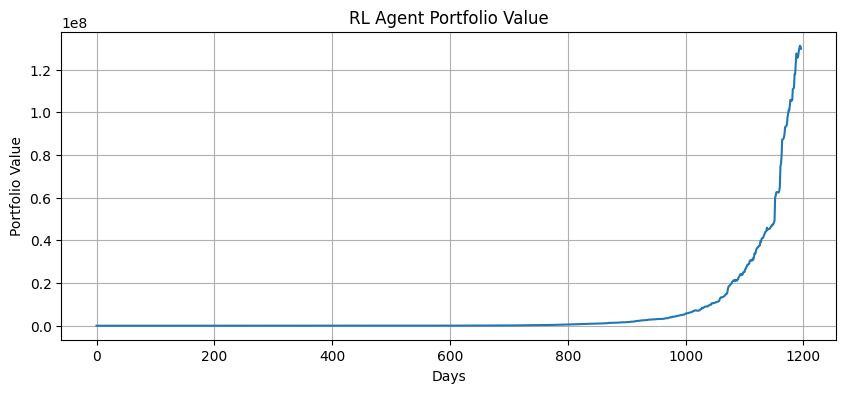

In [12]:
plt.figure(figsize=(10, 4))
plt.plot(history)
plt.title("RL Agent Portfolio Value")
plt.xlabel("Days")
plt.ylabel("Portfolio Value")
plt.grid(True)
plt.show()


This result is not realistic, the reasons could be :
- look ahead bias : using price_t and return_t
- using the same data for training and evaluating
- no constraints
- no transaction costs, ...
- maybe try a different objective, which penalizes big vol (sharpe like objective)

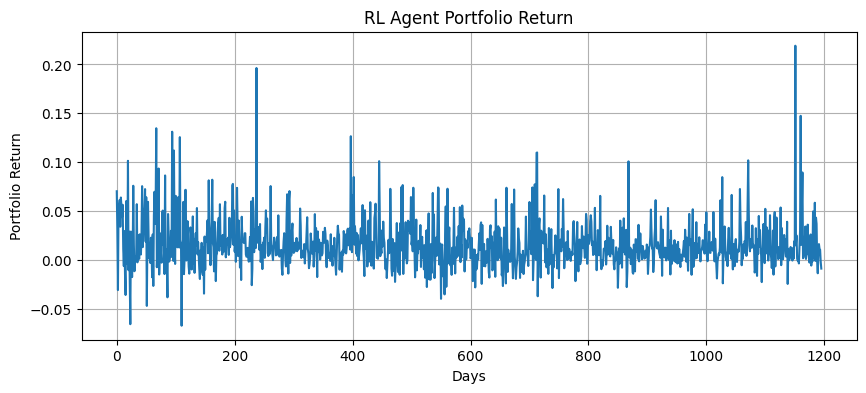

In [13]:
plt.figure(figsize=(10, 4))
plt.plot(infos_df['portfolio_return'])
plt.title("RL Agent Portfolio Return")
plt.xlabel("Days")
plt.ylabel("Portfolio Return")
plt.grid(True)
plt.show()

Allocation over time

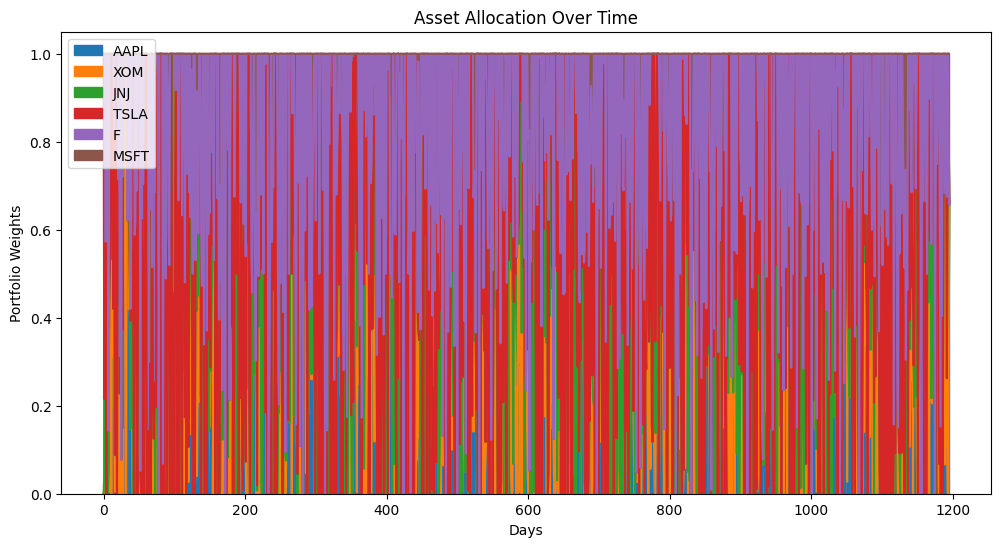

In [20]:
weights_df = pd.DataFrame([info['weights'] for info in infos])
weights_df.columns = ['AAPL', 'XOM', 'JNJ', 'TSLA', 'F', 'MSFT']
weights_df.plot.area(figsize=(12, 6))
plt.title("Asset Allocation Over Time")
plt.ylabel("Portfolio Weights")
plt.xlabel("Days")
plt.legend(loc='upper left')


alignement with market regimes

In [23]:
# Assuming features_df has hmm_0, hmm_1, hmm_2
hmm_regimes = features_df[[col for col in features_df.columns if col.startswith("hmm_")]].idxmax(axis=1)
hmm_regimes = hmm_regimes.str.extract("hmm_(\d+)").astype(int) 
hmm_regimes = hmm_regimes[0].values

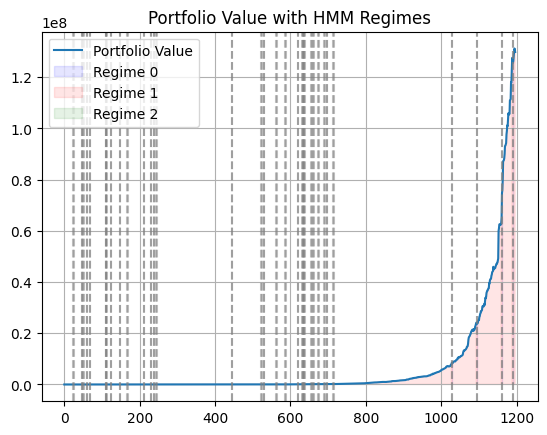

In [25]:
plt.plot(history, label="Portfolio Value")

plt.fill_between(range(len(hmm_regimes)), 0, history, where=hmm_regimes==0, color='blue', alpha=0.1, label='Regime 0')
plt.fill_between(range(len(hmm_regimes)), 0, history, where=hmm_regimes==1, color='red', alpha=0.1, label='Regime 1')
plt.fill_between(range(len(hmm_regimes)), 0, history, where=hmm_regimes==2, color='green', alpha=0.1, label='Regime 2')

for i in range(1, len(hmm_regimes)):
    if hmm_regimes[i] != hmm_regimes[i - 1]:
        plt.axvline(x=i, color='grey', linestyle='--', alpha=0.5)

plt.legend()
plt.title("Portfolio Value with HMM Regimes")
plt.grid(True)
plt.show()

# Next Step : Compare our policy vs other methods like Markowitz